- Reference
    - https://tcwang0509.github.io/pix2pixHD/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import os
import imageio
import pickle
from torch.utils.data import Dataset, DataLoader

from utils import *
from modules import DanceImageDataset

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

# 1. Load sample data

In [3]:
img_dir = "./data/subject4/train/train_img/"
stick_dir = "./data/subject4/train/train_label/"

In [4]:
sample_img = img_dir + os.listdir(img_dir)[0]
sample_stick = stick_dir + os.listdir(stick_dir)[0]
im = imageio.imread(sample_img)
im2 = imageio.imread(sample_stick)
print("img shape:",im.shape)
print("stick shape:",im2.shape)

img shape: (512, 1024, 3)
stick shape: (512, 1024, 3)


0 (512, 1024, 3) (512, 1024, 3)
1 (512, 1024, 3) (512, 1024, 3)
2 (512, 1024, 3) (512, 1024, 3)
3 (512, 1024, 3) (512, 1024, 3)


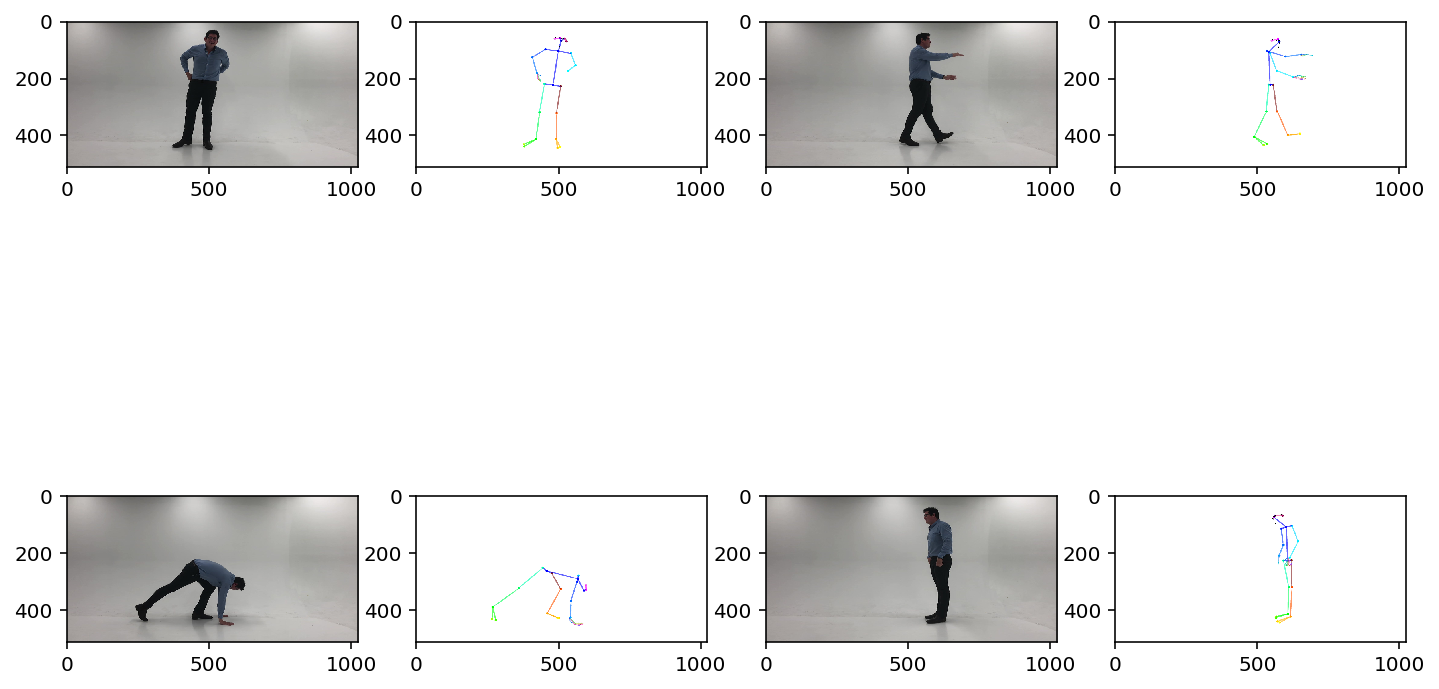

In [5]:
list_pkl_file = "./data/pickle/frame_name_list.pickle"
dance_dataset = DanceImageDataset(img_dir, stick_dir, list_pkl_file, transform=False)

fig = plt.figure(figsize=(12,8))

for i in range(len(dance_dataset)):
    sample = dance_dataset[i]

    print(i, sample['image'].shape, sample['stick'].shape)
    
    row = 2
    column = 4
    fig.add_subplot(row, column, i*2 + 1)
    plt.imshow(sample['image'])
    fig.add_subplot(row, column, i*2 + 2)
    plt.imshow(sample['stick'])

    if i == 3:
        plt.show()
        break

# 2. Load BatchLoader

In [6]:
dance_dataset2 = DanceImageDataset(img_dir, stick_dir, list_pkl_file, transform=True)
train_loader = DataLoader(dataset=dance_dataset2, batch_size=2, shuffle=True, num_workers=2)

In [7]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['stick'].size())
    if i_batch == 2:
        break

0 torch.Size([2, 3, 512, 1024]) torch.Size([2, 3, 512, 1024])
1 torch.Size([2, 3, 512, 1024]) torch.Size([2, 3, 512, 1024])
2 torch.Size([2, 3, 512, 1024]) torch.Size([2, 3, 512, 1024])


---

# 3. Global Part

### pix2pixHD 원본 코드 참고

- https://github.com/NVIDIA/pix2pixHD/blob/master/models/networks.py

In [8]:
def convolution_calculator(w, k, s, p):
    return (w-k+2*p)/s + 1
convolution_calculator(1024, 4, 2, 1)

512.0

In [9]:
sample_batch = sample_batched['image']

## 3-1. Global Generator

In [10]:
class Residual_Block(nn.Module):
    """
    Reference: https://github.com/NVIDIA/pix2pixHD/blob/master/models/networks.py
    """
    def __init__(self, n_channels, padding_type, norm_layer, 
                 activation=nn.ReLU(inplace=True), dropout_rate=0.5):
        super(Residual_Block, self).__init__()
        self.convolution_block = self.build_convolution_block(n_channels, padding_type, 
                                                              norm_layer, activation, dropout_rate)
        
    def build_convolution_block(self, n_channels, padding_type, norm_layer, activation, dropout_rate):
        """
        weight_layer -> activation -> weight_layer -> skip_connection
        """
        # build convolution block
        convolution_block_1 = []
        convolution_block_2 = []
        
        # add padding
        n_pad = 0
        if padding_type == 'reflect':
            convolution_block_1.append(nn.ReflectionPad2d(1))
            convolution_block_2.append(nn.ReflectionPad2d(1))
        elif padding_type == 'replicate':
            convolution_block_1.append(nn.ReplicationPad2d(1))
            convolution_block_2.append(nn.ReflectionPad2d(1))
        else:
            n_pad = 1
            
        # add first convolution
        convolution_block_1 += [nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=1, padding=n_pad),
                                norm_layer(n_channels), activation]
            
        # add second convolution
        convolution_block_2 += [nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=1, padding=n_pad),
                             norm_layer(n_channels)]
        
        # check dropout
        if dropout_rate:
            convolution_block_1.append(nn.Dropout(dropout_rate))
        
        # concatelate convolution blocks
        convolution_block = convolution_block_1 + convolution_block_2
        
        return nn.Sequential(*convolution_block)
    
    def forward(self, x):
        return x + self.convolution_block(x) 

In [11]:
class Global_Encoder(nn.Module):
    """
    todo -> deconvolution
    """
    def __init__(self):
        super(Global_Encoder, self).__init__()
        self.layer_list = self._build_layer()
        self.model = nn.Sequential(*self.layer_list)
        
    def _c7s1_k(self, c_in, c_out):
        """
        Description
        -----------
        reflection pad(3) -> 7*7 convolution(stride=1) -> instance norm -> relu
        
        Args
        ----
        c_in: channel in
        c_out: channel out, same as k
        """
        layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(c_out),
            nn.ReLU(inplace=True)
        )
        return layer
    
    def _dk(self, c_in, c_out):
        """
        Description
        -----------
        3*3 convolution(stride=2) -> instance norm -> relu
        
        Args
        ----
        c_in: channel in
        c_out: channel out, same as k
        """
        layer = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(c_out),
            nn.ReLU(inplace=True)
        )
        return layer
    
    def _uk(self, c_in, c_out):
        """
        Description
        -----------
        3*3 deconvolution -> instance norm -> relu
        
        Args
        ----
        c_in: channel in
        c_out: channel out, same as k
        """
        layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=c_in, out_channels=c_out, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(c_out),
            nn.ReLU(inplace=True)
        )
        return layer
    
    def _build_layer(self):
        layer_list = [self._c7s1_k(3,64)] 
        layer_list += [self._dk(64,128), self._dk(128,256), self._dk(256,512), self._dk(512,1024)]
        for i in range(9):
            layer_list += [Residual_Block(n_channels=1024, padding_type="reflect", norm_layer=nn.BatchNorm2d, )]
        layer_list += [self._uk(1024, 512), self._uk(512, 256), self._uk(256, 128), self._uk(128, 64)]
        layer_list += [self._c7s1_k(64,3)] 
        return layer_list
        
    
    def forward(self, x):
        out = self.model(x)
        return out

In [ ]:
GE = Global_Encoder()
GE_out = GE.forward(sample_batch)
print(GE_out.shape)

## 3-2. Global Discriminator

In [ ]:
class Global_Discriminator(nn.Module):
    """
    todo -> complete building the layer
    """
    def __init__(self):
        super(Global_Encoder, self).__init__()
        self.layer_list = self._build_layer()
        self.model = nn.Sequential(*self.layer_list)
        
    def _ck(self, c_in, c_out, use_instanceNorm=True):
        """
        Description
        -----------
        reflection pad(3) -> 4*4 convolution(stride=2) -> instance norm(optional) -> leaky_relu
        
        Args
        ----
        c_in: channel in
        c_out: channel out, same as k
        """
        if use_instanceNorm:
            layer = nn.Sequential(
                nn.ReflectionPad2d(3),
                nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=4, stride=2, padding=0),
                nn.InstanceNorm2d(c_out),
                nn.LeakyReLU(0.2, True),
            )
        else:
            layer = nn.Sequential(
                nn.ReflectionPad2d(3),
                nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=4, stride=2, padding=0),
                nn.LeakyReLU(0.2, True),
            )
        return layer
    
    def _build_layer(self):
        layer_list = []
        return layer_list
        
    
    def forward(self, x):
        out = self.model(x)
        return out

## 3.1 convolution

In [42]:
# layer 1
layer1 = nn.Conv2d(3, 64, 4, 2, 1)
out1 = layer1(sample_batch)
print(f"{sample_batch.shape} => {out1.shape}")

torch.Size([32, 3, 512, 1024]) => torch.Size([32, 64, 256, 512])


In [46]:
# layer 2
layer2 = nn.Conv2d(64, 128, 4, 2, 1)
out2 = layer2(out1)
print(f"{out1.shape} => {out2.shape}")

torch.Size([32, 64, 256, 512]) => torch.Size([32, 128, 128, 256])


In [47]:
# layer 3
layer3 = nn.Conv2d(128, 256, 4, 2, 1)
out3 = layer3(out2)
print(f"{out2.shape} => {out3.shape}")

torch.Size([32, 128, 128, 256]) => torch.Size([32, 256, 64, 128])


In [48]:
# layer 4
layer4 = nn.Conv2d(256, 512, 4, 2, 1)
out4 = layer4(out3)
print(f"{out3.shape} => {out4.shape}")

torch.Size([32, 256, 64, 128]) => torch.Size([32, 512, 32, 64])


In [49]:
# layer 5
layer5 = nn.Conv2d(512, 512, 4, 2, 1)
out5 = layer5(out4)
print(f"{out4.shape} => {out5.shape}")

torch.Size([32, 512, 32, 64]) => torch.Size([32, 512, 16, 32])


In [50]:
# layer 6
layer6 = nn.Conv2d(512, 512, 4, 2, 1)
out6 = layer6(out5)
print(f"{out5.shape} => {out6.shape}")

torch.Size([32, 512, 16, 32]) => torch.Size([32, 512, 8, 16])


In [50]:
# layer 6
layer6 = nn.Conv2d(512, 512, 4, 2, 1)
out6 = layer6(out5)
print(f"{out5.shape} => {out6.shape}")

torch.Size([32, 512, 16, 32]) => torch.Size([32, 512, 8, 16])


In [59]:
# layer 7
layer7 = nn.Conv2d(512, 512, 4, 2, 1)
out7 = layer7(out6)
print(f"{out6.shape} => {out7.shape}")

torch.Size([32, 512, 8, 16]) => torch.Size([32, 512, 4, 8])


In [60]:
# layer 8
layer8 = nn.Conv2d(512, 512, 4, 2, 1)
out8 = layer8(out7)
print(f"{out7.shape} => {out8.shape}")

torch.Size([32, 512, 4, 8]) => torch.Size([32, 512, 2, 4])


In [61]:
# layer 9
layer9 = nn.Conv2d(512, 512, (2,4), 2, 0)
out9 = layer9(out8)
print(f"{out8.shape} => {out9.shape}")

torch.Size([32, 512, 2, 4]) => torch.Size([32, 512, 1, 1])


## 3.2 deconvolution